- connecting to colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Faculdade/NLP/final-project/

/content/drive/MyDrive/Faculdade/NLP/final-project


# NLP Final Project

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Bidirectional, GRU, LSTM, Embedding, Conv1D, GlobalAveragePooling1D, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import spacy

In [4]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Data Preprocessing

In [5]:
from tqdm import tqdm


def load_txt_file(path):
    train_df = pd.read_csv(f"{path}/train.txt", sep=';', header=None, names=['Text', 'Label'])
    test_df = pd.read_csv(f"{path}/test.txt", sep=';', header=None, names=['Text', 'Label'])


    train_texts = train_df['Text'].tolist()
    train_labels = train_df['Label'].tolist()

    test_texts = test_df['Text'].tolist()
    test_labels = test_df['Label'].tolist()


    return train_texts, train_labels, test_texts, test_labels

train_texts, train_labels, test_texts, test_labels = load_txt_file('NLP_exam_emotions_dataset')

train_texts= np.asarray(train_texts)
train_labels= np.asarray(train_labels)
test_texts= np.asarray(test_texts)
test_labels= np.asarray(test_labels)

In [6]:
set(train_labels)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [7]:
def preprocess_labels(train_labels, test_labels):
    labels_map = {
        'anger': 0.0,
        'fear': 1.0,
        'joy': 2.0,
        'love': 3.0,
        'sadness': 4.0,
        'surprise': 5.0,
    }

    test_labels_int = [labels_map[x] for x in test_labels]
    train_labels_int = [labels_map[x] for x in train_labels]

    ohe_train_labels = to_categorical(train_labels_int, num_classes=6)
    ohe_test_labels = to_categorical(test_labels_int, num_classes=6)

    return ohe_train_labels, ohe_test_labels

def tokenize_and_pad_sequences(train_texts, test_texts):
    oov_tok = "<OOV>"

    tokenizer = Tokenizer(num_words = 5000, oov_token = oov_tok )
    tokenizer.fit_on_texts(train_texts)

    vocab_size = len(tokenizer.word_index)+1

    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    train_padded = pad_sequences(train_sequences, truncating='post', maxlen=120)
    test_padded = pad_sequences(test_sequences, maxlen=120)

    return train_padded, test_padded, vocab_size


ohe_train_labels, ohe_test_labels = preprocess_labels(train_labels,test_labels)
train_texts_pad, test_texts_pad, vocab_size= tokenize_and_pad_sequences(train_texts, test_texts)

## Fully Connected Neural Network

In [8]:
model = tf.keras.models.Sequential([
    Embedding(vocab_size, 64, input_length=120),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           973696    
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 64)                491584    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1

In [53]:

history = model.fit(train_texts_pad, ohe_train_labels, epochs = 50, batch_size= 100, validation_data=(test_texts_pad, ohe_test_labels))


Epoch 1/50
160/160 [==============================] - 5s 24ms/step - loss: 1.8582 - accuracy: 0.3186 - val_loss: 1.6472 - val_accuracy: 0.3475
Epoch 2/50
160/160 [==============================] - 4s 22ms/step - loss: 1.6148 - accuracy: 0.3349 - val_loss: 1.5023 - val_accuracy: 0.4610
Epoch 3/50
160/160 [==============================] - 5s 30ms/step - loss: 1.3756 - accuracy: 0.4668 - val_loss: 1.1911 - val_accuracy: 0.5930
Epoch 4/50
160/160 [==============================] - 4s 22ms/step - loss: 1.1247 - accuracy: 0.6399 - val_loss: 1.0564 - val_accuracy: 0.6970
Epoch 5/50
160/160 [==============================] - 4s 22ms/step - loss: 1.0119 - accuracy: 0.7072 - val_loss: 1.0001 - val_accuracy: 0.7180
Epoch 6/50
160/160 [==============================] - 4s 23ms/step - loss: 0.9390 - accuracy: 0.7237 - val_loss: 0.9662 - val_accuracy: 0.7230
Epoch 7/50
160/160 [==============================] - 5s 29ms/step - loss: 0.8933 - accuracy: 0.7366 - val_loss: 0.9564 - val_accuracy: 0.7150

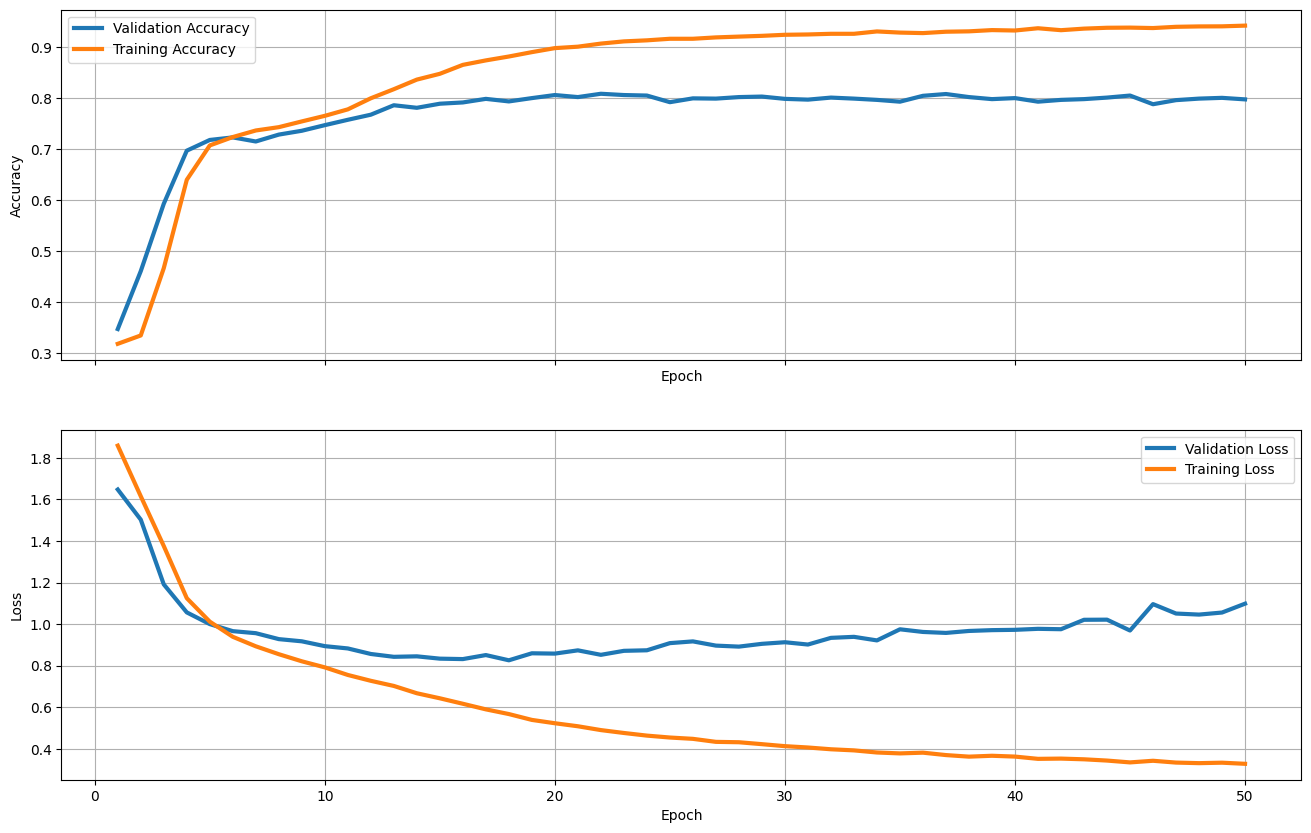

In [54]:
plot_results(history)

## Recurrent Neural Network

In [33]:
model = tf.keras.models.Sequential([
    Embedding(vocab_size, 64, input_length=120),
    Bidirectional(LSTM(32, dropout=0.5)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Dropout(0.5),
    Dense(6, activation='sigmoid')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 64)           973696    
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 6)                 102       
                                                                 
Total params: 999670 (3.81 MB)
Trainable params: 999670 (3.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:

history = model.fit(train_texts_pad, ohe_train_labels, epochs = 50, batch_size= 100, validation_data=(test_texts_pad, ohe_test_labels))

Epoch 1/50
160/160 [==============================] - 17s 83ms/step - loss: 1.7355 - accuracy: 0.3294 - val_loss: 1.6180 - val_accuracy: 0.3475
Epoch 2/50
160/160 [==============================] - 4s 27ms/step - loss: 1.5418 - accuracy: 0.3699 - val_loss: 1.3151 - val_accuracy: 0.5140
Epoch 3/50
160/160 [==============================] - 4s 26ms/step - loss: 1.0939 - accuracy: 0.6183 - val_loss: 0.8471 - val_accuracy: 0.7220
Epoch 4/50
160/160 [==============================] - 3s 19ms/step - loss: 0.7529 - accuracy: 0.7657 - val_loss: 0.7544 - val_accuracy: 0.7840
Epoch 5/50
160/160 [==============================] - 2s 15ms/step - loss: 0.6457 - accuracy: 0.8021 - val_loss: 0.6464 - val_accuracy: 0.8045
Epoch 6/50
160/160 [==============================] - 3s 17ms/step - loss: 0.5664 - accuracy: 0.8281 - val_loss: 0.5819 - val_accuracy: 0.8230
Epoch 7/50
160/160 [==============================] - 2s 15ms/step - loss: 0.4710 - accuracy: 0.8658 - val_loss: 0.4835 - val_accuracy: 0.862

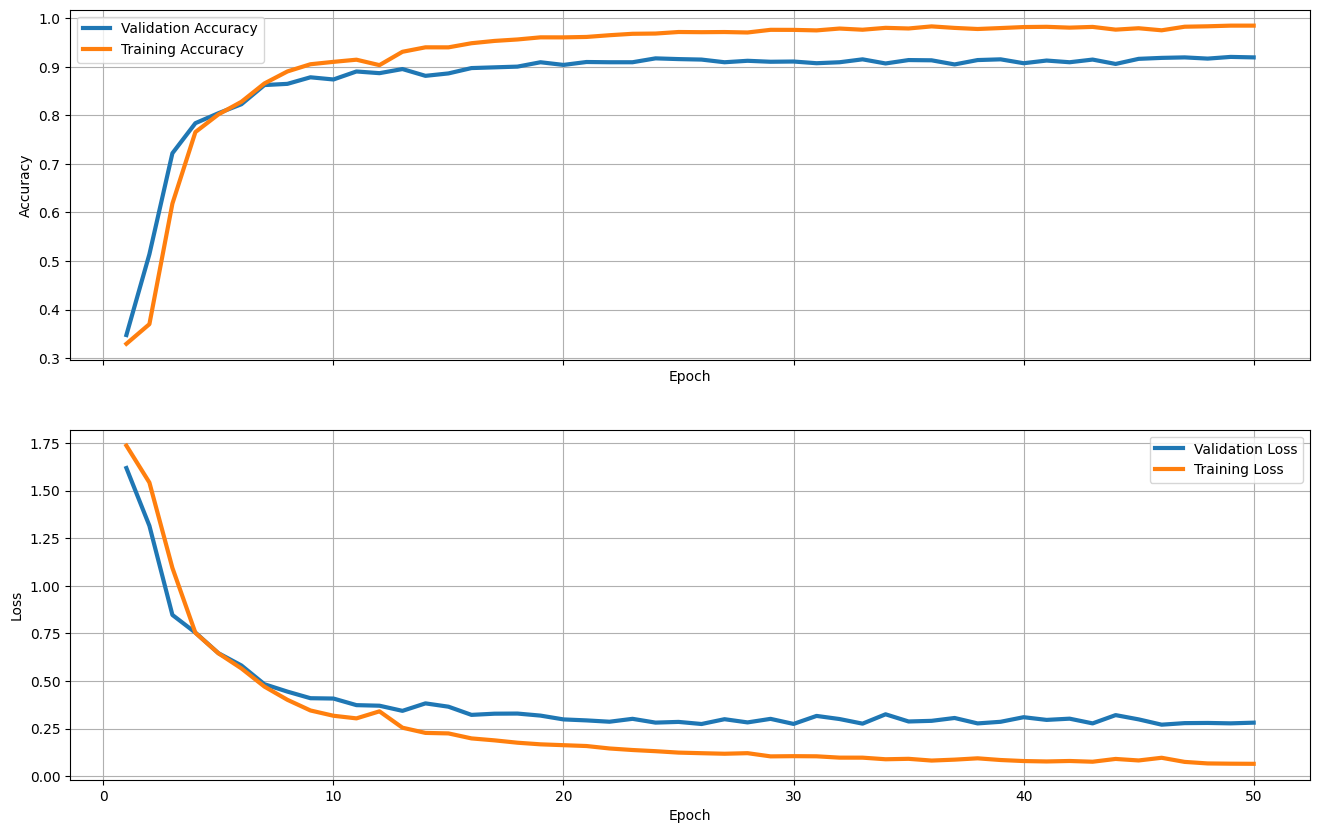

In [36]:
plot_results(history)